데이터 전처리
----------

In [110]:
#### 데이터 전처리 단계 #### 

getwd()
setwd("/Users/jihye/Downloads")

library("tidyverse")
user <- read_csv("user_infos.csv") 
event <- read_csv("event_logs.csv")
item <- read_csv("item_infos.csv")

#head(user)
#head(event)
#head(item)

colnames(user) <- c("user_id", "device_os", "age_group", "install_type")
colnames(item) <- c("item_id", "price", "category_id")

#### data merging #### 
library("dplyr")
user_event <- left_join(user, event, by = c('user_id')) 
data_merge <- right_join(user_event, item, by = c('item_id')) 


#category_id 기반으로 구입한 상품 종류 매칭하여 삽입
data_merge =  data_merge %>%
               mutate(ctg_product = ifelse(category_id == 173, "pants", 
                                    ifelse(category_id == 342, "top", 
                                    ifelse(category_id == 769, "outer", 
                                    ifelse(category_id == 806, "accessory",  
                                    ifelse(category_id == 984, "bag", 
                                    ifelse(category_id == 1007, "onepiece", 
                                    ifelse(category_id == 1069, "shoes",
                                    ifelse(category_id == 1301, "skirts", NA)))))))))

#### time data wrangling #### 
data_merge$date <- as.Date(data_merge$timestamp) 
data_merge$hour <- hour(data_merge$timestamp) 
data_merge$time <- format(as.POSIXct(data_merge$timestamp) ,format = "%H:%M:%S") 

#right_join 과정에서 발생한 na값 제거 
sum(is.na(data_merge))
data_merge <- na.omit(data_merge)

#순수 이용자수 측정을 위한 중복 user id 제거 
df <- data_merge
df = df[!duplicated(df$user_id),]

#data_merge 파일 추출 -  중복 user id 포함
write.csv(data_merge, "data_merge.csv")
#data_merge %>% 
#    write.csv(.,file = "~/Desktop/data_merge.csv")

view = subset(data_merge, event == "view")
#general_user = subset(data_merge, event == "add_to_cart")
pur_user = subset(data_merge, event == "transaction") 

[1] "/Users/jihye/Downloads"

Parsed with column specification:
cols(
  id = col_character(),
  device_os = col_character(),
  age_group = col_character(),
  install_type = col_character()
)
Parsed with column specification:
cols(
  timestamp = col_datetime(format = ""),
  user_id = col_character(),
  event = col_character(),
  item_id = col_integer()
)
Parsed with column specification:
cols(
  id = col_integer(),
  price = col_double(),
  category_id = col_integer()
)


[1] 511398

In [111]:
#### 분석에 필요한 테이블 데이터 작성 - 뷰어 #### 
library("data.table") 
library("plyr")
view <- data.table(view) #viewing user 데이터를 데이터 테이블로 변환. 데이터 처리의 효율성을 위해 data.table library 선택 
dt <- data.table(df)

#연령대별 뷰 품목 분포
agectg_view = view[, .N, by = .(age_group, ctg_product)] %>% dcast(age_group ~ ctg_product)
view_ctg = count(view,'ctg_product')

#어떤 품목을 많이 보는지
v_ctg = count(view,'ctg_product')
#유입 os 경로 
v_os = count(view, 'device_os')
#연령대별 사용자 수 
view2 = subset(dt, event == "view") #user_id 중복값을 제거한 후 view 조건을 충족하는 데이터를 추출 
v_agegroup = count(view2, 'age_group')


Using 'N' as value column. Use 'value.var' to override


Exploratory Data Analysis with the plot
------------------------------------ 


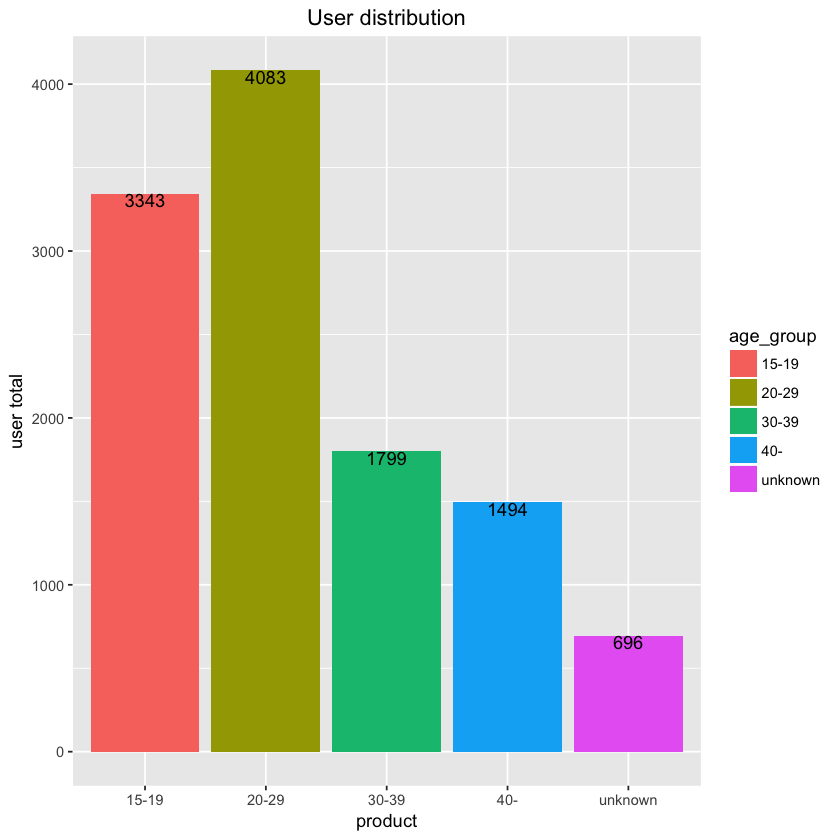

In [112]:
library(ggplot2)
g10 <- ggplot(data = v_agegroup, aes(x = age_group, y = freq, group = age_group)) +
       labs(title = "User distribution", x = "product", y = "user total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = age_group), position = "dodge") +
       geom_text(aes(label = freq), vjust = 1)

g10

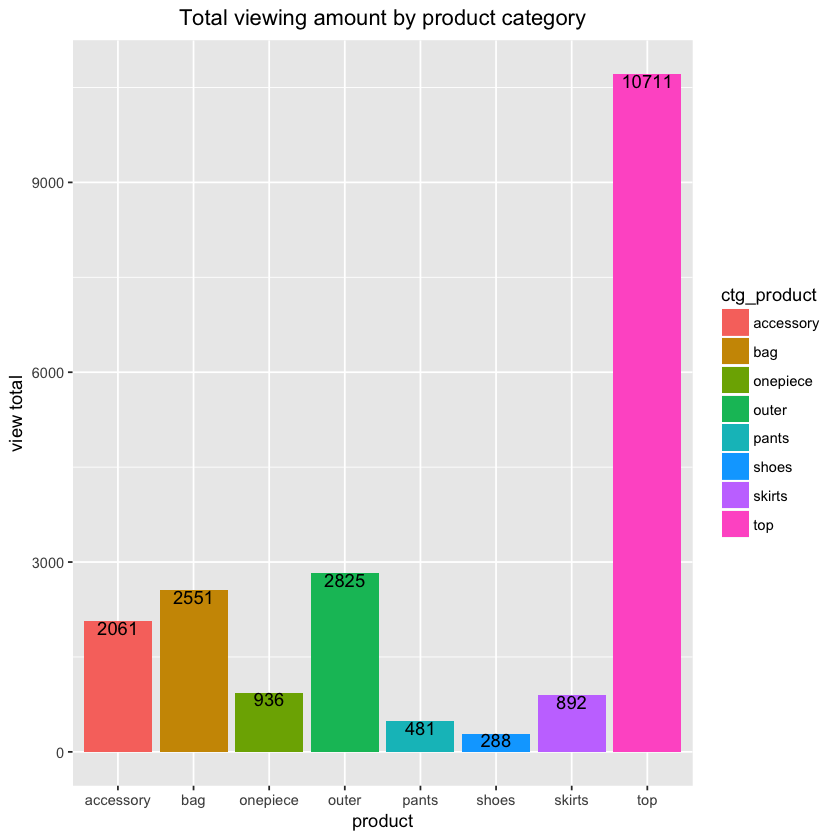

In [114]:
library(ggplot2)
g6 <- ggplot(data = view_ctg, aes(x = ctg_product, y = freq, group = ctg_product)) +
       labs(title = "Total viewing amount by product category", x = "product", y = "view total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = ctg_product), position = "dodge") +
       geom_text(aes(label = freq), vjust = 1)

g6

In [115]:
#### 분석에 필요한 테이블 데이터 작성 - 구입자 #### 

pur_user <- data.table(pur_user)
#연령대별 구매액 합계 
age = pur_user[, sum(price), by = "age_group"]
#유입경로 별 구매액 합계 
install = pur_user[, sum(price), by = "install_type"]
#연령대별 구매 발생수 
purchase = pur_user[, count(event), by = "age_group"]
#연령대별 구매 품목 분포
agectg = pur_user[, .N, by = .(age_group, ctg_product)] %>% dcast(age_group ~ ctg_product)
#ref: https://stackoverflow.com/questions/44373694/how-do-i-compute-the-frequency-table-of-categorical-variables-by-group-with-r-da


#어떤 품목 많이 구입하는지 
category = count(pur_user,'ctg_product')
#유입 os 
os = count(data_merge, 'device_os')
#연령대별 사용자 수 
agegroup = count(dt, 'age_group') #중복 id 제외 
agegroup_id = count(data_merge, 'age_group') #중복 id 포함

Using 'N' as value column. Use 'value.var' to override


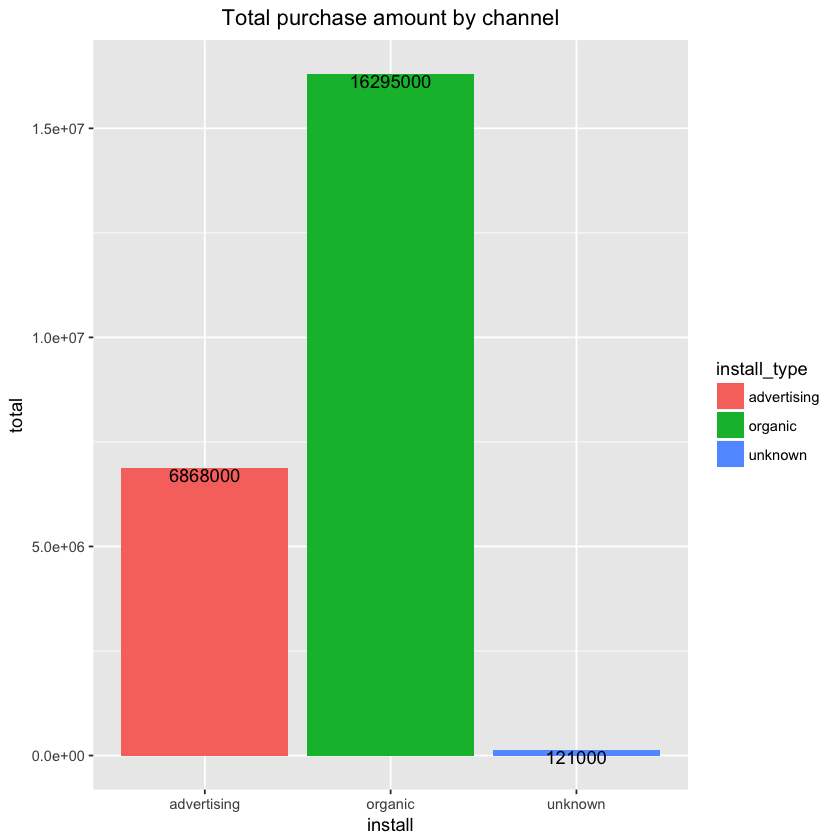

In [116]:
library(ggplot2)
g1 <- ggplot(data = install, aes(x = install_type, y = V1, group = install_type)) +
       labs(title = "Total purchase amount by channel", x = "install", y = "total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = install_type), position = "dodge") +
       geom_text(aes(label = V1), vjust = 1)

g1

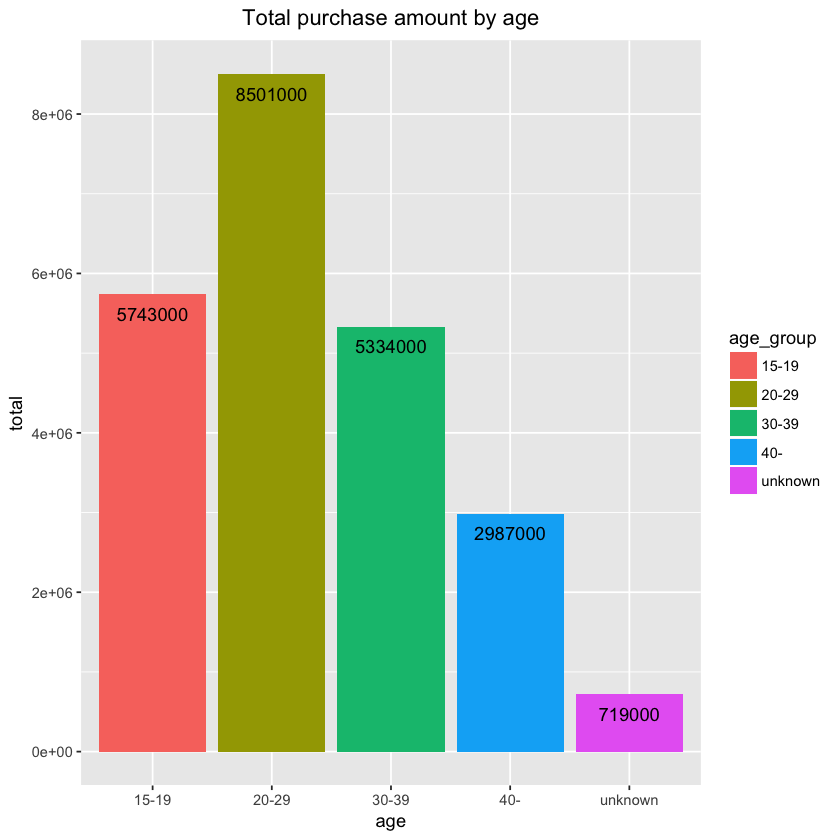

In [119]:
g2 <- ggplot(data = age, aes(x = age_group, y = V1, group = age_group)) +
       labs(title = "Total purchase amount by age", x = "age", y = "total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = age_group), position = "dodge") +
       geom_text(aes(label = V1), vjust = 2)
g2

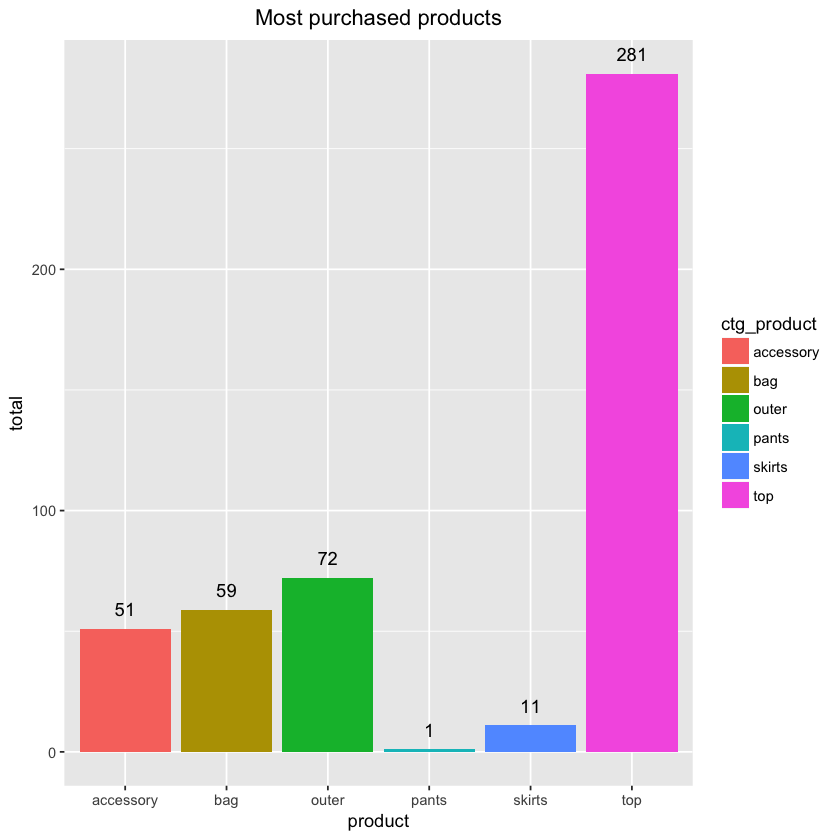

In [121]:
g3 <- ggplot(data = category, aes(x = ctg_product, y = freq, group = ctg_product)) +
       labs(title = "Most purchased products", x = "product", y = "total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = ctg_product), position = "dodge") +
       geom_text(aes(label = freq), vjust = -1)
g3

In [122]:
#### 분석에 필요한 테이블 데이터 작성 - 시간 #### 

#data_merge$date = date(data_merge$timestamp)  #date의 경우 2017-10-30으로 시간이 동일하여 분석할 수 없었음 

hour_count = count(data_merge,"hour")
pur_hour_c = count(pur_user,"hour")
view_hour_c = count(view,"hour")


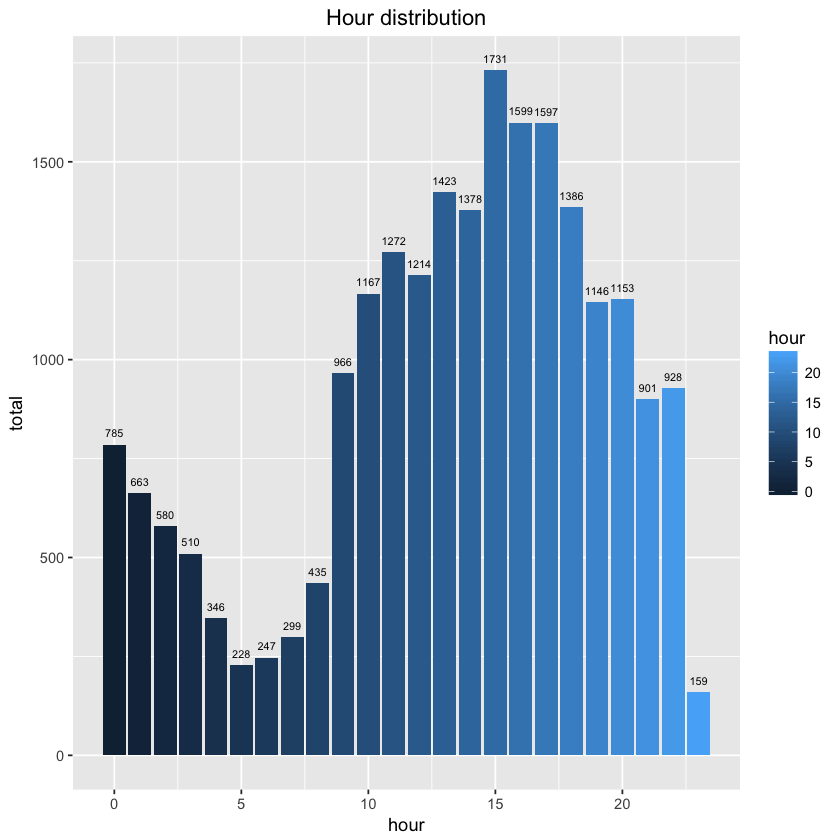

In [123]:
gh1 <- ggplot(data = hour_count, aes(x = hour, y = freq, group = hour)) +
       labs(title = "Hour distribution", x = "hour", y = "total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = hour), position = "dodge") +
       geom_text(aes(label = freq), vjust = -1, size=2.3)
gh1

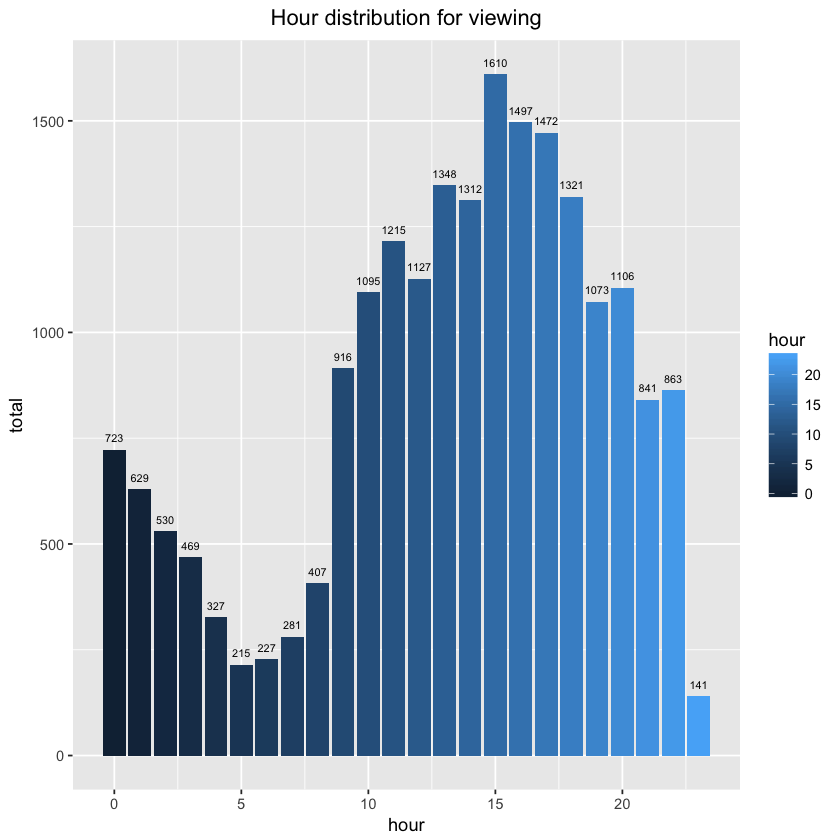

In [124]:
gh3 <- ggplot(data = view_hour_c, aes(x = hour, y = freq, group = hour)) +
       labs(title = "Hour distribution for viewing", x = "hour", y = "total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = hour), position = "dodge") +
       geom_text(aes(label = freq), vjust = -1, size=2.3)
gh3

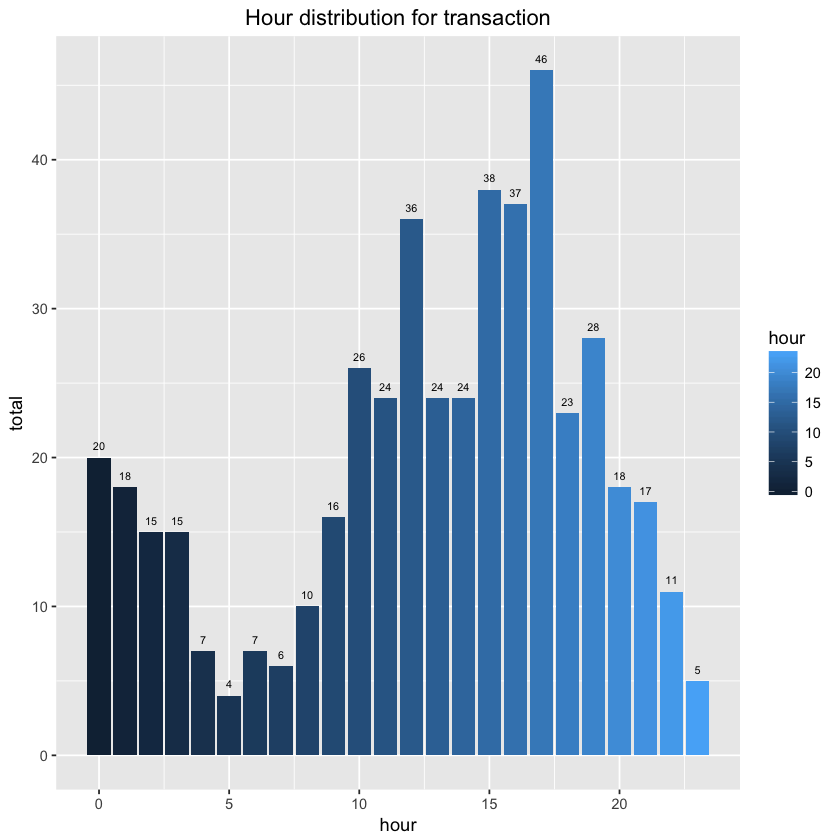

In [125]:
gh2 <- ggplot(data = pur_hour_c, aes(x = hour, y = freq, group = hour)) +
       labs(title = "Hour distribution for transaction", x = "hour", y = "total") + 
       theme(plot.title = element_text(hjust = 0.5)) +
       geom_col(aes(fill = hour), position = "dodge") +
       geom_text(aes(label = freq), vjust = -1, size=2.3)
gh2